# HM1 algorithms and hyperparameters tuning

# Algorithms 

SVM

k nn

Random forest

# Data

44 spam

1067 nasa https://www.openml.org/search?type=data&status=active&id=1067

1464 blood-transfusion-service-center

40701 churn

### Libraries

In [19]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import openml
from skopt import BayesSearchCV
from sklearn import svm

### Data input

In [20]:
dataset = {}
data = {}
labels = {}
id = [44,1067,1464,40701]
for index in id:
    dataset[index] = openml.datasets.get_dataset(index)
    data[index], y, _, _ = dataset[index].get_data(dataset_format="dataframe")
    data[index] = data[index].replace('nan', np.nan) # not always needed
    labels[index] = list(data[index].columns.values)

c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\AWeg\AppData\Local\Programs\Python\Python39\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\Users\AWeg\AppData\Local\Prog

### Preprocessing

In [21]:
def preprocess():
    num_pipeline = Pipeline(steps=[
        ('scale',MinMaxScaler())
    ])

    ### operacje dla kolumn kategorycznych
    cat_pipeline = Pipeline(steps=[
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))

    ])

    bool_pipeline = Pipeline(steps=[])

    col_trans = ColumnTransformer(transformers=[
        ('num_pipeline', num_pipeline, make_column_selector( dtype_exclude= np.object_)),
        ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= np.object_)),
        ],
    
        n_jobs=-1)
    
    model = Pipeline([('preprocessing', col_trans)])
    return model

In [22]:
data_prepared = {}
for index in id:
    datad = data[index]
    model =  preprocess()
    model.get_params()
    model.fit(datad)
    after_process = model.transform(datad)
    data_prepared[index] = pd.DataFrame(after_process, columns = labels[index])

### Data split

In [23]:
yColumnName = {44:"class",1067:"defects",1464:"Class",40701:"class"}
X = {}
y = {}
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for index in id:

    X[index] = data_prepared[index].drop(yColumnName[index], axis=1)
    y[index] = data_prepared[index][yColumnName[index]]

    X_train[index],  X_test[index], y_train[index], y_test[index] = train_test_split(X[index], y[index])

## Grid search for tuning hyperparams

### RandomForestClassifier

In [24]:
pipeline = Pipeline([('SVM', svm.SVC())])

In [25]:
pipeline.get_params()

{'memory': None,
 'steps': [('SVM', SVC())],
 'verbose': False,
 'SVM': SVC(),
 'SVM__C': 1.0,
 'SVM__break_ties': False,
 'SVM__cache_size': 200,
 'SVM__class_weight': None,
 'SVM__coef0': 0.0,
 'SVM__decision_function_shape': 'ovr',
 'SVM__degree': 3,
 'SVM__gamma': 'scale',
 'SVM__kernel': 'rbf',
 'SVM__max_iter': -1,
 'SVM__probability': False,
 'SVM__random_state': None,
 'SVM__shrinking': True,
 'SVM__tol': 0.001,
 'SVM__verbose': False}

In [26]:

svm_c = np.linspace(10, 200, 10).astype(np.float_)
coef0 = np.linspace(1, 50, 5).astype(np.float_)
gamma = 1/np.linspace(1, 500, 5).astype(np.float_)
degree =  np.linspace(1, 10, 10).astype(np.int_)


In [27]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

In [28]:
param_distributions = [{
                'SVM__kernel': kernel,
                'SVM__C' : svm_c,
                'SVM__coef0': coef0 , 
                'SVM__gamma': gamma,
                'SVM__degree': degree
                }]

In [29]:
best_hyperparams = []
score_for_best_hyperparams = {}
std_scores = []
all_scores = {}
# ps = PredefinedSplit(test_fold=1)

for index in id:
    gs_model_pipeline = RandomizedSearchCV(estimator=pipeline,param_distributions=param_distributions,scoring='roc_auc',cv=2, n_iter=10, random_state=1)
    gs_model_pipeline.fit(X[index], y[index])
    best_hyperparams.append(gs_model_pipeline.best_params_)

    #score for test data
    
    #score_for_best_hyperparams[index] = gs_model_pipeline.score(X_test[index], y_test[index])
    std_scores.append(gs_model_pipeline.cv_results_['mean_test_score'])
    all_scores[index] = gs_model_pipeline.cv_results_['mean_test_score']


In [ ]:
import matplotlib.pyplot as plt

for index in id:
    plt.plot(all_scores[index])

In [ ]:
best_hyperparams
gs_model_pipeline.cv_results_['mean_test_score']

array([0.74963295])

In [ ]:
mean_std_vector   = np.mean(std_scores, axis =0)
minimum_std = np.max(mean_std_vector)
index_best = np.where(mean_std_vector == (minimum_std))[0][0]

In [ ]:
for index in id:
    score_for_best_hyperparams[index] = np.max(all_scores[index])

In [ ]:
score_for_best_hyperparams

{44: 0.8880723776707038,
 1067: 0.7865552632619814,
 1464: 0.6966883500887049,
 40701: 0.7496329484645767}

In [ ]:
defaults = gs_model_pipeline.cv_results_['params'][index_best]

### Diff for defaults - best

In [ ]:
score_for_default_hyperparams = {}
diff = {}

for index in id:
    diff[index] = score_for_best_hyperparams[index] - all_scores[index][index_best]
diff

{44: 0.0, 1067: 0.0, 1464: 0.0, 40701: 0.0}

# Bayes Optimization

## BayesSearchCV

In [ ]:
# number of iters to change
iters = 50

bayes_params = param_distributions
best_hyperparams_bayes = []
all_scores_bayes = {}

for index in id:
    opt = BayesSearchCV(estimator=pipeline,search_spaces=bayes_params,scoring='roc_auc',cv=2, n_iter=iters, random_state=0)
    opt.fit(X[index], y[index])
    best_hyperparams_bayes.append(opt.best_params_)

    all_scores_bayes[index] = opt.cv_results_['mean_test_score']

NameError: name 'grid_params' is not defined

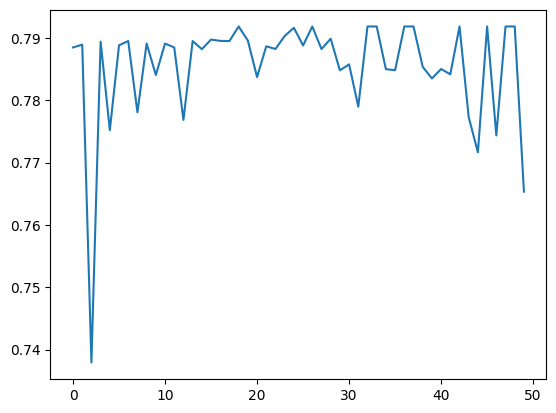

In [ ]:
import matplotlib.pyplot as plt


for index in id:
    plt.plot(all_scores_bayes[index])

# Defaults - BO

In [ ]:
minimum_std